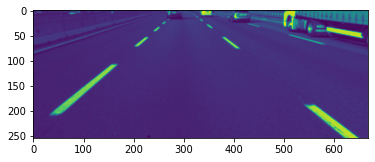

In [5]:
import cv2
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pylab
img = cv2.imread("road.jpg")
img_Gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_Gray)

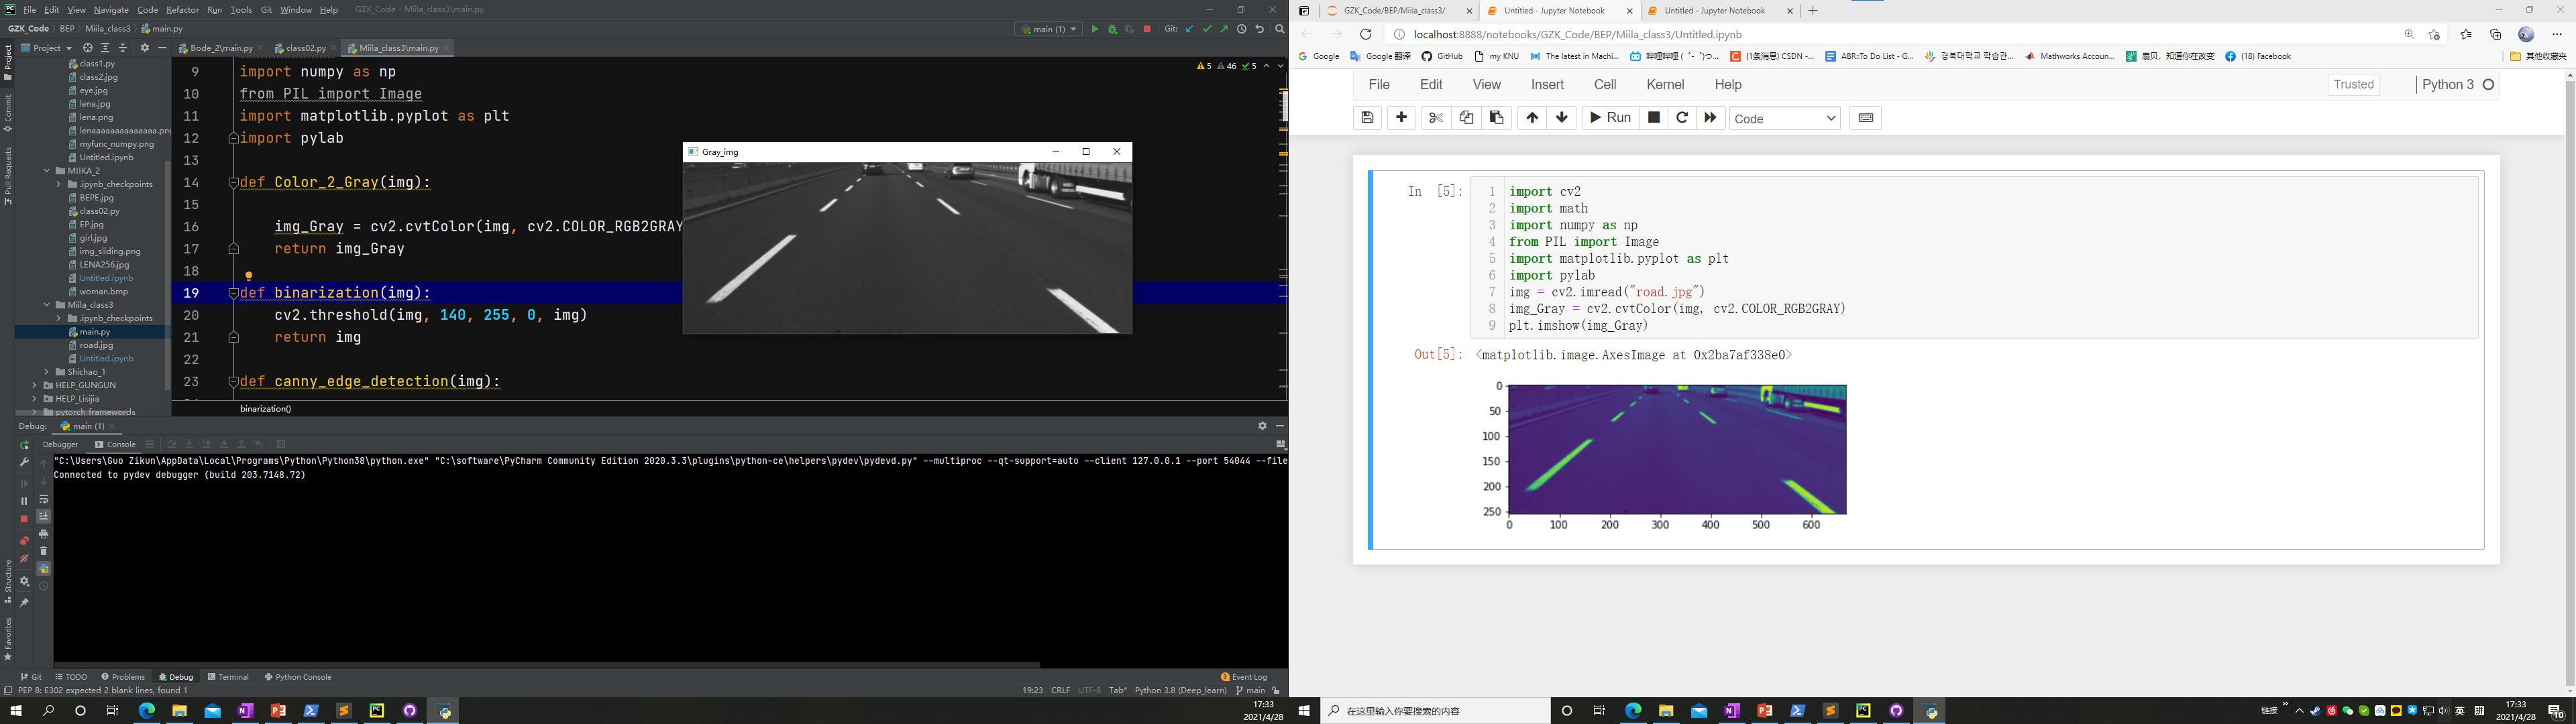

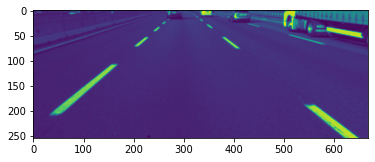

In [7]:
img = cv2.imread("road.jpg")
cv2.threshold(img, 140, 255, 0, img)
plt.imshow(img_Gray)

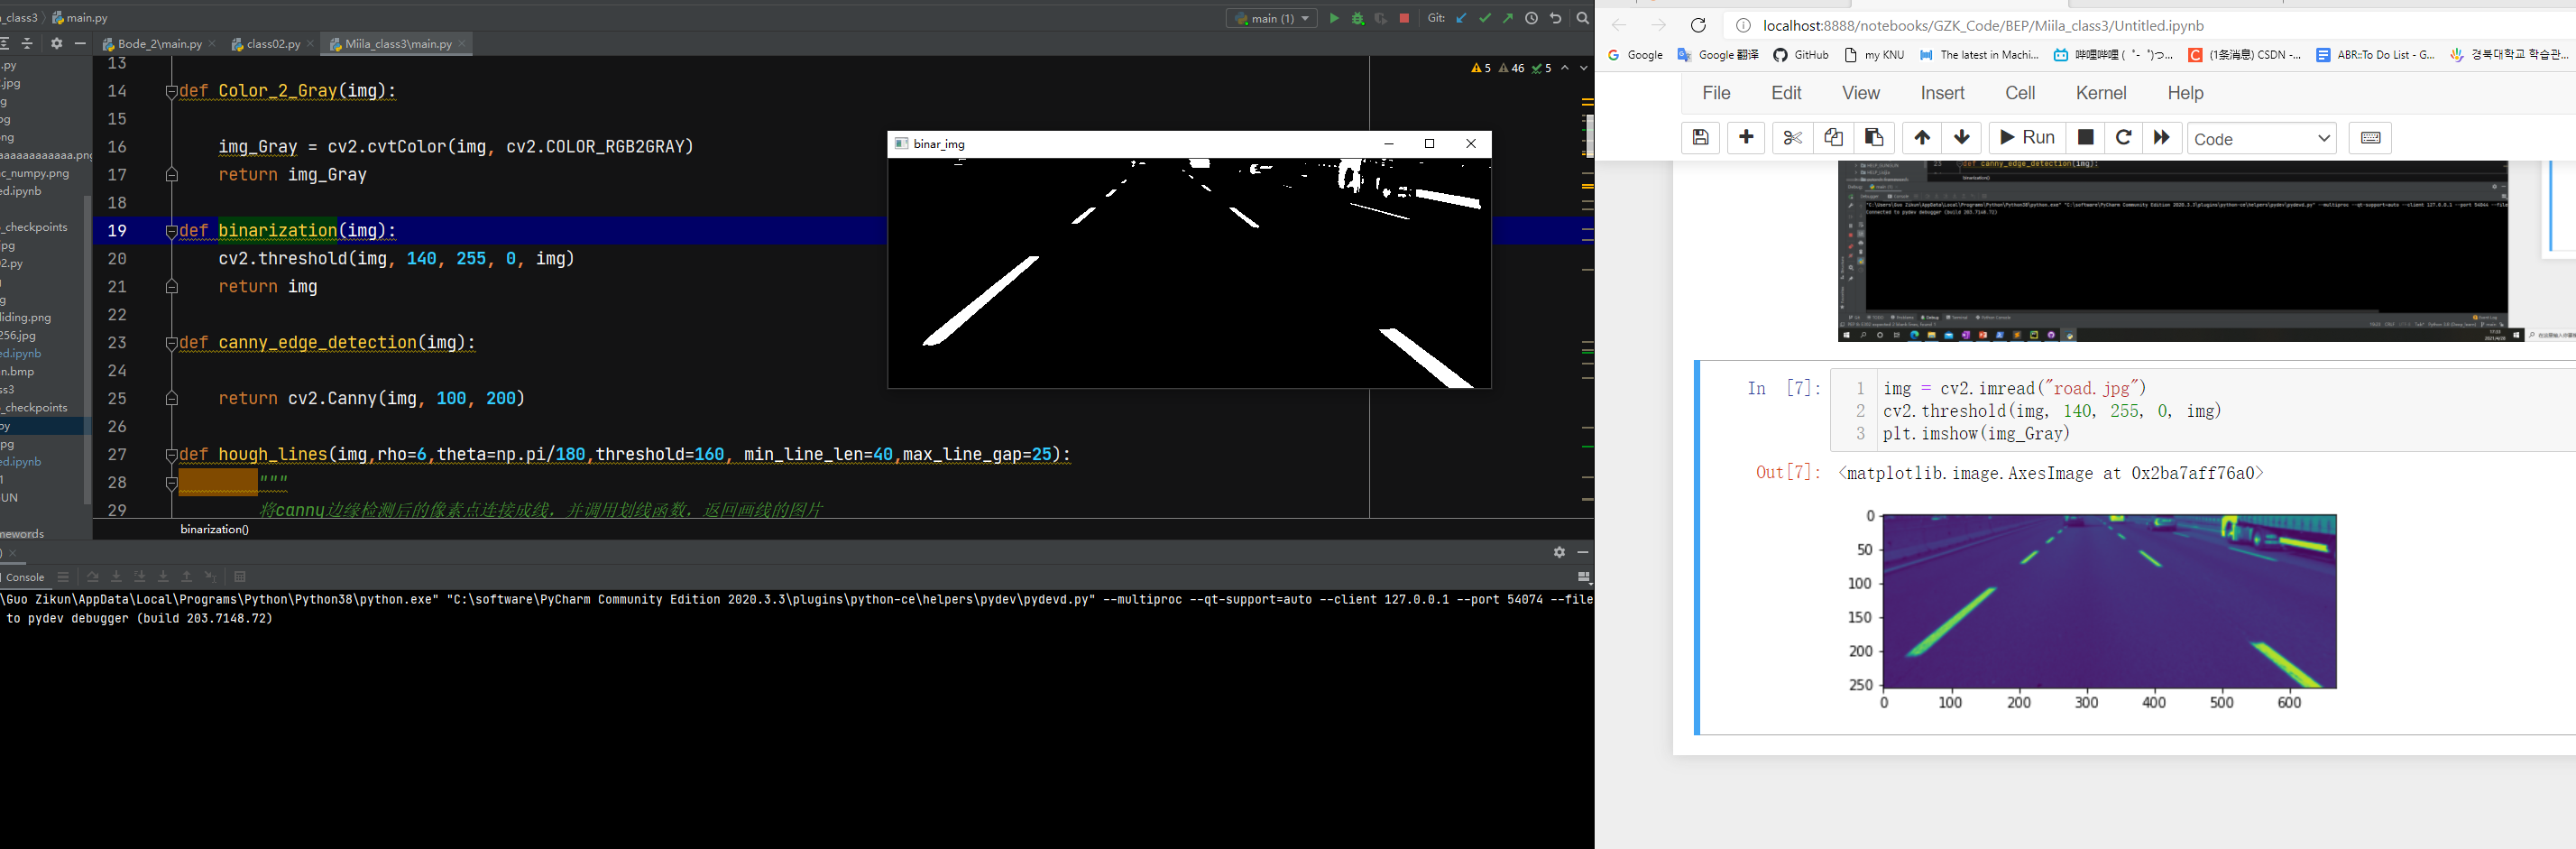

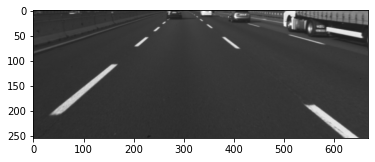

In [8]:
img = cv2.imread("road.jpg")
cv2.Canny(img, 100, 200)
plt.imshow(img)

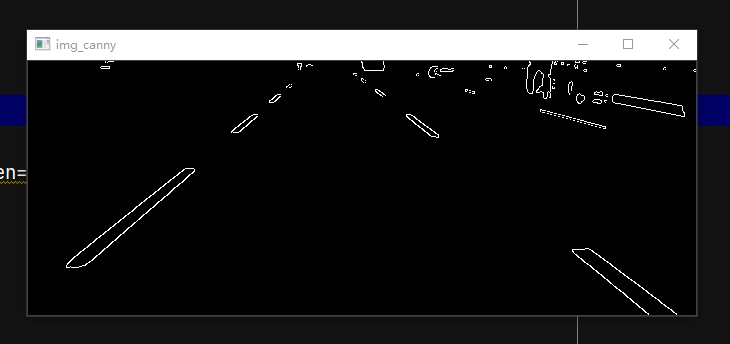

In [ ]:
def hough_lines(img,rho=6,theta=np.pi/180,threshold=160, min_line_len=40,max_line_gap=25):
        """
        将canny边缘检测后的像素点连接成线，并调用划线函数，返回画线的图片
        hough transform原理：转换到 hough space,r,θ极坐标，正弦曲线，
        每条线代表个image space中过一点的所有线，
        lines的交点代表共线，找到交点再返回到image space空间
        lines:[[x1,y1,x2,y2],[x x y y]...]
        """
        lines=cv2.HoughLinesP(img,rho,theta,threshold, np.array([]),
                              minLineLength=min_line_len, maxLineGap=max_line_gap)
        return lines

def draw_lines(img,lines,color=[255,0,0],thickness=3):
	"""
	生成一个zeros图划线，并与原图混合
	"""
	if lines is None:
		return
	img = np.copy(img)
	# 生成待划线的图,zeros，addweighted混合的时候，0值不会显示
	img_channels = img.shape[2]
	line_img = np.zeros((img.shape[0], img.shape[1], img_channels), dtype=np.uint8)
	for line in lines:
		for x1, y1, x2, y2 in line:
			cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
	# 将划线图与原图合并
	# cv2.addWeighted(initial_img, α, img, β , γ)
	# output: initial_img * α + img * β + γ
	img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)  # 叠加的两幅图片尺寸和channel需要一致
	return img


def group_lines_and_draw(img, lines):
	"""
	根据斜率，将所有的线分为左右两组,斜率绝对值小于0.5的舍去（影响不显著）
	（因为图像的原点在左上角，slope<0是left lines，slope>0是right lines)
	设定min_y作为left和right的top线,max_y为bottom线，求出四个x值即可确定直线：
	将left和right的点分别线性拟合，拟合方程根据y值，求出x值，画出lane
	"""
	left_x, left_y, right_x, right_y = [], [], [], []
	for line in lines:
		for x1, y1, x2, y2 in line:
			slope = (y2 - y1) / (x2 - x1)
			if abs(slope) < 0.5: continue
			if slope < 0:
				left_x.extend([x1, x2])
				left_y.extend([y1, y2])
			if slope > 0:
				right_x.extend([x1, x2])
				right_y.extend([y1, y2])
	# 设定top 和 bottom的y值，left和right的y值都一样
	min_y = int(img.shape[0] * (3 / 5))
	max_y = int(img.shape[0])

	# 对left的所有点进行线性拟合
	poly_left = np.poly1d(np.polyfit(left_y, left_x, deg=1))
	left_x_start = int(poly_left(max_y))
	left_x_end = int(poly_left(min_y))
	# 对right的所有点进行线性拟合
	poly_right = np.poly1d(np.polyfit(right_y, right_x, deg=1))
	right_x_start = int(poly_right(max_y))
	right_x_end = int(poly_right(min_y))

	line_image = draw_lines(img, [[
		[left_x_start, max_y, left_x_end, min_y],
		[right_x_start, max_y, right_x_end, min_y],
	]], thickness=5)
	return line_image
cv2.imshow("img_canny", img_canny)
cv2.waitKey()

lines = hough_lines(img_canny)

line_img=draw_lines(img,lines)
plt.imshow(line_img)
pylab.show()

final_image = group_lines_and_draw(img, lines)
plt.imshow(final_image)
pylab.show()

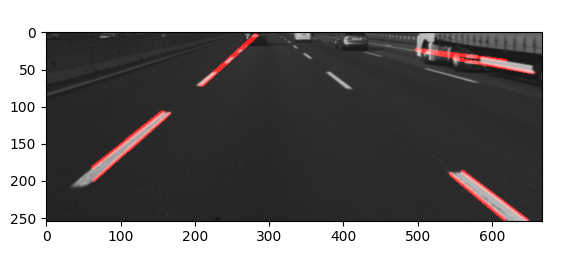

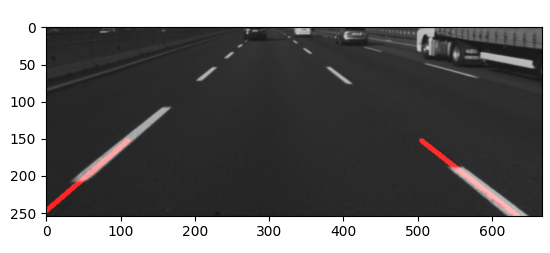